1. Importing the required libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
import re
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
from keras.layers import Embedding, Bidirectional, LSTM, GRU, Dense
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

2. Loading our dataset

In [ ]:
num_classes = 7
embed_num_dims = 300
max_seq_len = 500

class_names = ['joy', 'fear', 'anger', 'sadness', 'disgust', 'shame', 'guilt']

data_train = pd.read_csv('/content/drive/MyDrive/datasets/isear_.csv', encoding='utf-8')
data_test = pd.read_csv('/content/drive/MyDrive/datasets/isear.csv', encoding='utf-8')

X_train = data_train.Text
X_test = data_test.Text
y_train = data_train.Emotion
y_test = data_test.Emotion
data = data_train.append(data_test, ignore_index=True)

data.head()

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/datasets/isear_.csv'

3. Preprocessing (Tokenization, Padding, Encoding)

In [ ]:
# Tokenization
def preprocess_text(data):

    data = re.sub(r"(#[\d\w\.]+)", '', data)
    data = re.sub(r"(@[\d\w\.]+)", '', data)
    data = word_tokenize(data)

    return data

texts = [' '.join(preprocess_text(text)) for text in data.Text]

texts_train = [' '.join(preprocess_text(text)) for text in X_train]
texts_test = [' '.join(preprocess_text(text)) for text in X_test]

print(texts_train[29])

tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

sequence_train = tokenizer.texts_to_sequences(texts_train)
sequence_test = tokenizer.texts_to_sequences(texts_test)

index_of_words = tokenizer.word_index
vocab_size = len(index_of_words) + 1

print('Number of unique words: {}'.format(len(index_of_words)))

NameError: name 'data' is not defined

In [ ]:
# Padding
max_seq_len = 256
X_train_pad = pad_sequences(sequence_train, maxlen = max_seq_len )
X_test_pad = pad_sequences(sequence_test, maxlen = max_seq_len )

X_train_pad

array([[   0,    0,    0, ...,    1, 2715, 2007],
       [   0,    0,    0, ...,  557,  201,  190],
       [   0,    0,    0, ...,    9, 4682,   32],
       ...,
       [   0,    0,    0, ...,   10,    3,  127],
       [   0,    0,    0, ...,    7,  490,  865],
       [   0,    0,    0, ...,  225,   39, 1531]], dtype=int32)

In [ ]:
# Encoding
encoding = {
    'joy': 0,
    'fear': 1,
    'anger': 2,
    'sadness': 3,
    'disgust' : 4,
    'shame': 5,
    'guilt': 6
}

y_train = [encoding[x] for x in data_train.Emotion]
y_test = [encoding[x] for x in data_test.Emotion]

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

y_train

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

4. Word Embedding (using 300-dimensional word vectors pre-trained on Wikipedia articles)

In [ ]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word]
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]
    return embedding_matrix

In [ ]:
import urllib.request
import zipfile
import os

fname = 'embeddings/wiki-news-300d-1M.vec'

if not os.path.isfile(fname):
    print('Downloading word vectors...')
    urllib.request.urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip',
                              'wiki-news-300d-1M.vec.zip')
    print('Unzipping...')
    with zipfile.ZipFile('wiki-news-300d-1M.vec.zip', 'r') as zip_ref:
        zip_ref.extractall('embeddings')
    print('done.')

    os.remove('wiki-news-300d-1M.vec.zip')

embedd_matrix = create_embedding_matrix(fname, index_of_words, embed_num_dims)
embedd_matrix.shape

(9016, 300)

In [ ]:
new_words = 0

for word in index_of_words:
    entry = embedd_matrix[index_of_words[word]]
    if all(v == 0 for v in entry):
        new_words = new_words + 1

print('Words found in wiki vocab: ' + str(len(index_of_words) - new_words))
print('New words found: ' + str(new_words))

Words found in wiki vocab: 8461
New words found: 554


5. LSTM

In [ ]:
embedd_layer = Embedding(vocab_size,
                         embed_num_dims,
                         input_length = max_seq_len,
                         weights = [embedd_matrix],
                         trainable=False)

In [ ]:
lstm_output_size = 128
bidirectional = True


model = Sequential()
model.add(embedd_layer)

if bidirectional:
    model.add(Bidirectional(LSTM(units=lstm_output_size,
                              dropout=0.2,
                              recurrent_dropout=0.2)))
else:
     model.add(LSTM(units=lstm_output_size,
                dropout=0.2,
                recurrent_dropout=0.2))

model.add(Dense(num_classes, activation='softmax'))

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 256, 300)          2704800   
                                                                 
 bidirectional_6 (Bidirecti  (None, 256)               439296    
 onal)                                                           
                                                                 
 dense_6 (Dense)             (None, 7)                 1799      
                                                                 
Total params: 3145895 (12.00 MB)
Trainable params: 441095 (1.68 MB)
Non-trainable params: 2704800 (10.32 MB)
_________________________________________________________________


In [ ]:
batch_size = 128
epochs = 15

hist = model.fit(X_train_pad, y_train,
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_data=(X_test_pad,y_test))

Epoch 1/15
60/60 [==============================] - 240s 4s/step - loss: 1.8193 - accuracy: 0.3006 - val_loss: 1.5897 - val_accuracy: 0.4396
Epoch 2/15
60/60 [==============================] - 236s 4s/step - loss: 1.5171 - accuracy: 0.4468 - val_loss: 1.3842 - val_accuracy: 0.5039
Epoch 3/15
60/60 [==============================] - 235s 4s/step - loss: 1.3295 - accuracy: 0.5184 - val_loss: 1.2277 - val_accuracy: 0.5638
Epoch 4/15
60/60 [==============================] - 278s 5s/step - loss: 1.2416 - accuracy: 0.5597 - val_loss: 1.1123 - val_accuracy: 0.6107
Epoch 5/15
60/60 [==============================] - 276s 5s/step - loss: 1.1619 - accuracy: 0.5894 - val_loss: 1.0876 - val_accuracy: 0.6205
Epoch 6/15
60/60 [==============================] - 232s 4s/step - loss: 1.1329 - accuracy: 0.5989 - val_loss: 1.0141 - val_accuracy: 0.6427
Epoch 7/15
60/60 [==============================] - 276s 5s/step - loss: 1.0911 - accuracy: 0.6096 - val_loss: 1.0062 - val_accuracy: 0.6481
Epoch 8/15
60

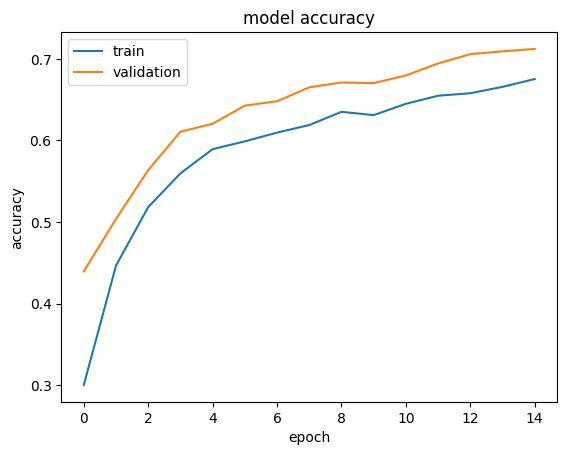

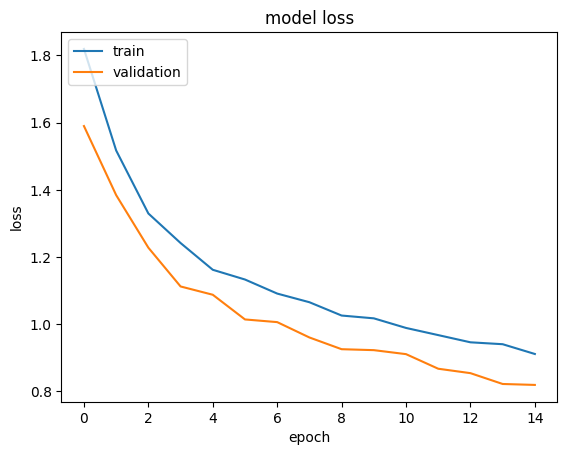

In [ ]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
predictions = model.predict(X_test_pad)
predictions = np.argmax(predictions, axis=1)
predictions = [class_names[pred] for pred in predictions]
print("Accuracy: {:.2f}%".format(accuracy_score(data_test.Emotion, predictions) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(data_test.Emotion, predictions, average='micro') * 100))

234/234 [==============================] - 44s 189ms/step
Accuracy: 71.22%

F1 Score: 71.22


In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):

    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()


    fig.set_size_inches(12.5, 7.5)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)


    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),

           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')


    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


F1 Score: 71.22


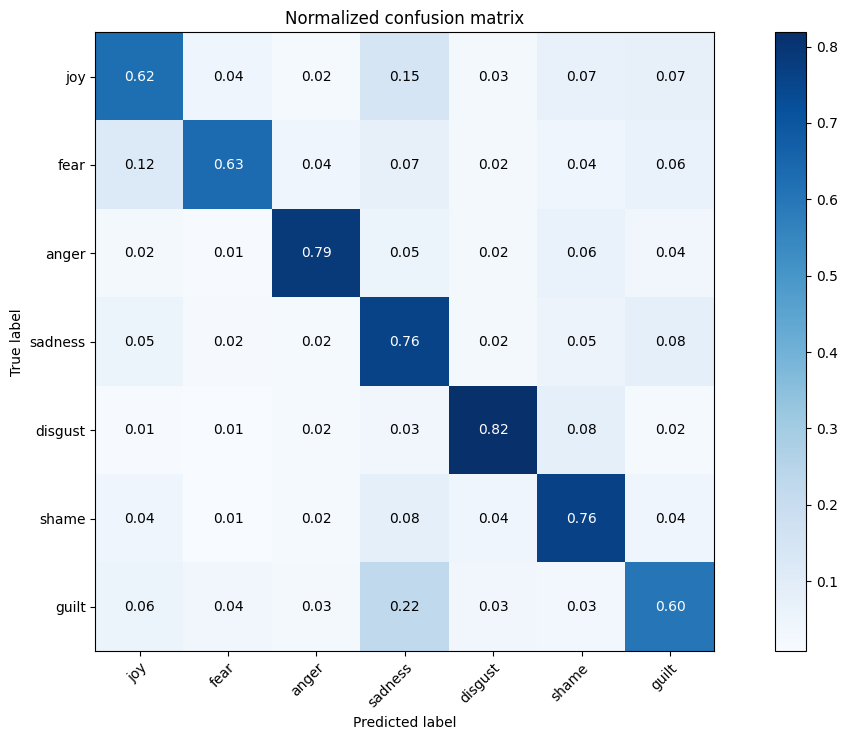

In [ ]:
print("\nF1 Score: {:.2f}".format(f1_score(data_test.Emotion, predictions, average='micro') * 100))

# Plot normalized confusion matrix
plot_confusion_matrix(data_test.Emotion, predictions, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

In [ ]:
print('Message: {}\nPredicted: {}'.format(X_test[4], predictions[4]))

Message: The time I knocked a deer down - the sight of the animal's injuries and helplessness.  The realization that the animal was so badly hurt that it had to be put down, and when the animal screamed at the moment of death.
Predicted: fear


In [ ]:
import time

message = ['that food has been left hanging for an hour']

seq = tokenizer.texts_to_sequences(message)
padded = pad_sequences(seq, maxlen=max_seq_len)

start_time = time.time()
pred = model.predict(padded)

print('Message: ' + str(message))
print('predicted: {} ({:.2f} seconds)'.format(class_names[np.argmax(pred)], (time.time() - start_time)))

NameError: name 'tokenizer' is not defined

In [ ]:
# !cp -r "/content/datasets" "/content/drive/MyDrive"

In [ ]:
model.save('models/biLSTM_w2v.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# !cp -r "/content/models" "/content/drive/MyDrive"